In [578]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np

In [579]:


trainFile = "D:/GitHub/Datasets/books.csv"

pwd = os.getcwd()
os.chdir(os.path.dirname(trainFile))
trainData = pd.read_csv(os.path.basename(trainFile),error_bad_lines=False)
os.chdir(pwd)

# The Good Reads dataset provides a list of books from the website with their respective ratings.
#### Questions to pose for hypothesis are:
* Does the reoccurance of a book through different publications bias the rating?
* Does the ratings count and text review counts affect the rating 
* Does the popularity of the author affect the rating?

In [580]:
df =trainData

In [581]:
#explore if any missing values or nans

no_nulls = set(df.columns[df.isnull().mean()>0])
no_nulls

{'Unnamed: 10'}

In [582]:
df=df.drop(['Unnamed: 10'], axis=1)

## We now have a dataset with no NaNs

In [583]:
#verifying if Average ratings has any missing vlaues placed as 0

missing_data=df.loc[df['average_rating'] == 0]

missing_data.shape[0]


0

In [584]:
#dropping records with missing ratings 

indexNames = df[ df['average_rating'] == 0 ].index
df.drop(indexNames , inplace=True)

## Now that we have a cleaner dataset, time to continue exploring the data

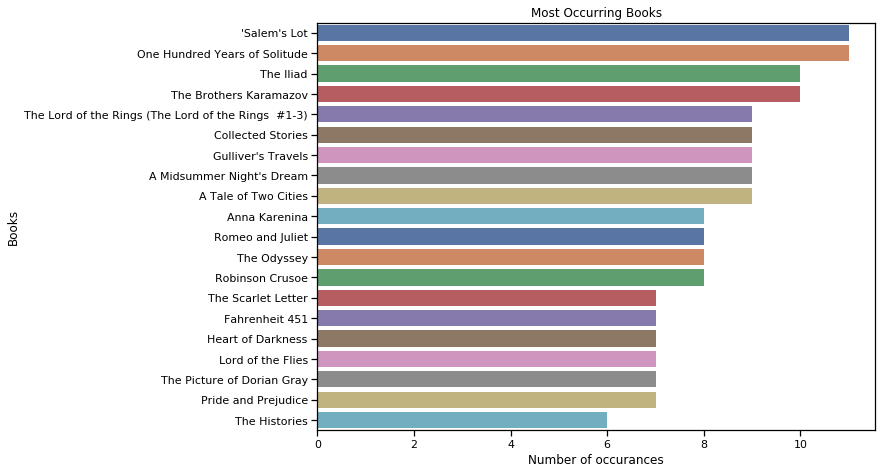

In [585]:
#checking the books with the highest re-occurance

#Taking the first 20:

sns.set_context('notebook')
plt.figure(figsize=(10,7.5))
books = df['title'].value_counts()[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

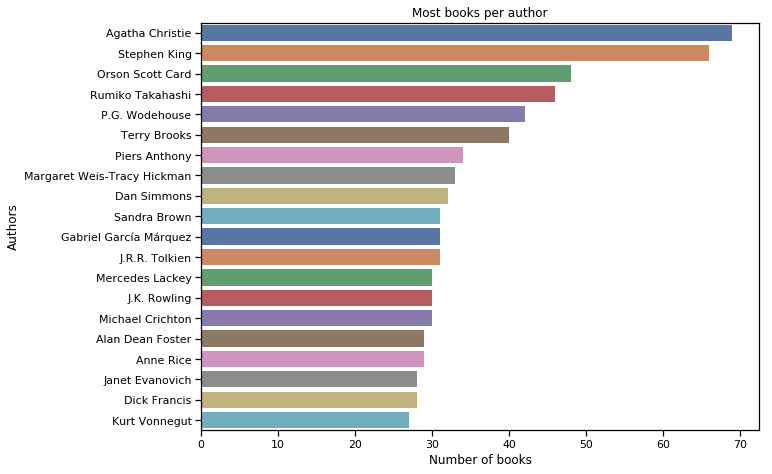

In [586]:
#checking the authors with the highest number of books written

sns.set_context('notebook')
plt.figure(figsize=(10,7.5))
books = df['authors'].value_counts()[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most books per author")
plt.xlabel("Number of books")
plt.ylabel("Authors")
plt.show()

### With Agatha Christie at number one with 68 books, we have a clear ranking of the authors based on volume of books written. No surprise there as Hercule Poirot is a favorite among many :)

In [587]:
#Checking Data types to ensure correct types relevant to the column data

df.dtypes

bookID                 int64
title                 object
authors               object
average_rating        object
isbn                  object
isbn13                object
language_code         object
# num_pages           object
ratings_count          int64
text_reviews_count     int64
dtype: object

oops, it seems like average rating & number of pages are not in the right format. After attempting to convert average_rating to float I received an error that shows that some entries are corrupt. i.e with names instead of numbers. Hence the conversion failed.

In [588]:
#converting average rating and number of pages to numeric

df['average_rating'] = pd.to_numeric(df['average_rating'],errors='coerce')
df['# num_pages'] = pd.to_numeric(df['# num_pages'],errors='coerce')

In [589]:
#verifying the conversion has been done

df.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                 object
language_code          object
# num_pages           float64
ratings_count           int64
text_reviews_count      int64
dtype: object

From the above exploration, it seems that we sstill have some cleaning to do. 
* A) there are a few records with high ratings (5) but very low ratings count which is rationally not a real representation of the rating of the books so those need to be droppe. 
* B) many records with 0 rating and 0 ratings count wich would bias our data to a lower count

In [590]:
df.ratings_count.describe()

count    1.371900e+04
mean     1.775903e+04
std      1.129371e+05
min      0.000000e+00
25%      8.300000e+01
50%      6.300000e+02
75%      4.737000e+03
max      5.629932e+06
Name: ratings_count, dtype: float64

In [591]:
#removing books with ratings count less than 10 to ensure books with only enough ratings count are kept to avoid fan bias


indexNames = df[ df['ratings_count'] < 10 ].index
df.drop(indexNames , inplace=True)

indexNames = df[ df['average_rating'] == 0 ].index
df.drop(indexNames , inplace=True)

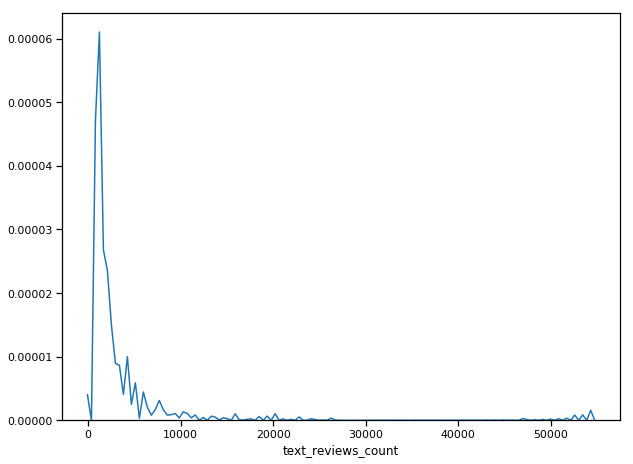

In [592]:
sns.set_context('notebook')
plt.figure(figsize=(10,7.5))
books = df.groupby(['authors']).mean()
ratings_sorted=books.sort_values(by=['average_rating'],ascending=False)
sns.distplot(ratings_sorted['text_reviews_count'], bins=5, hist=False);

In [593]:
#cleaning up some nans found due to dropping records with no ratings

no_nulls = set(df.columns[df.isnull().mean()>0])
no_nulls

{'# num_pages', 'average_rating'}

In [594]:
df=df.dropna()

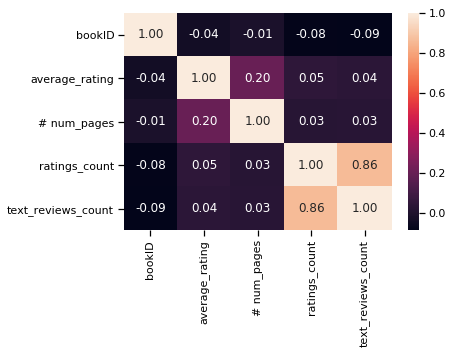

In [595]:
#checking the correlation of features in the current dataframe

sns.heatmap(df.corr(), annot=True, fmt=".2f");

### From the above analysis, we can see that there is a correlation between the number of pages and the average rating. Further more, there is a a strong correlation between the ratings count and the text reviews count. 

<Figure size 1080x720 with 0 Axes>

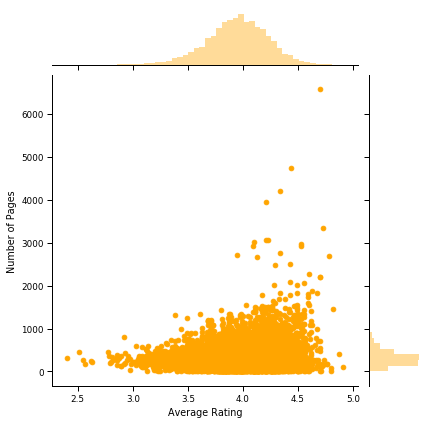

In [596]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="# num_pages", data = df, color = 'orange')
ax.set_axis_labels("Average Rating", "Number of Pages")

### There seems to be quite a few outliers above the 1300 pages mark, so lets strip those first and repeat.

In [597]:
pages_df=df[df['# num_pages']<900]

<Figure size 1080x720 with 0 Axes>

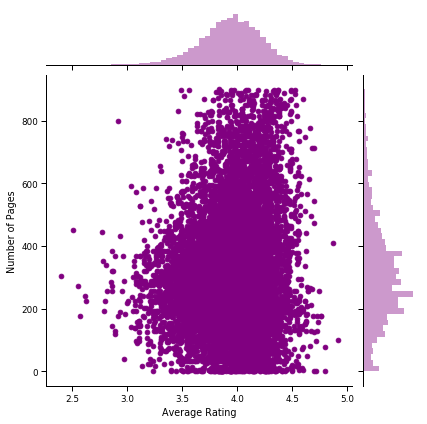

In [598]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="# num_pages", data = pages_df, color = 'purple')
ax.set_axis_labels("Average Rating", "Number of Pages")

### From the above graph we can see that the correlation between number of pages and the average rating is within the 200-400 page range. Which infers that people prefer shroter books than large daunting ones.

# Predicting the Average Rating based on the number of pages, the ratings count and the text reviews count:

In [599]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Creating a function for reusability

def ratingsPred(df, responsecol):
    '''
    Inputs:
    df = the dataframe to be processed with all columns 
    responsecol = the column to be predicted
    
    Outputs:
    rsquare_score of the prediciton
    
    
    '''
    # splitting the dataset into the features and target column:
    y = df[responsecol]
    X = df.drop(responsecol, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    # instantiating the model
    lm_model = LinearRegression(normalize=True) 

    #Fit
    lm_model.fit(X_train, y_train)

    # predict values
    y_preds=lm_model.predict(X_test)


    #Rsquared and y_test
    rsquared_score = r2_score(y_test, y_preds)
    length_y_test = len(y_test)

    return "The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)


In [600]:

responsecol = 'average_rating'
subdf = df[['average_rating','# num_pages','ratings_count','text_reviews_count']]
ratingsPred(subdf,responsecol)

'The r-squared score for your model was 0.04813462733472407 on 3820 values.'

## Now lets see if we can improve the model by adding any of the categorical columns we have such as language code

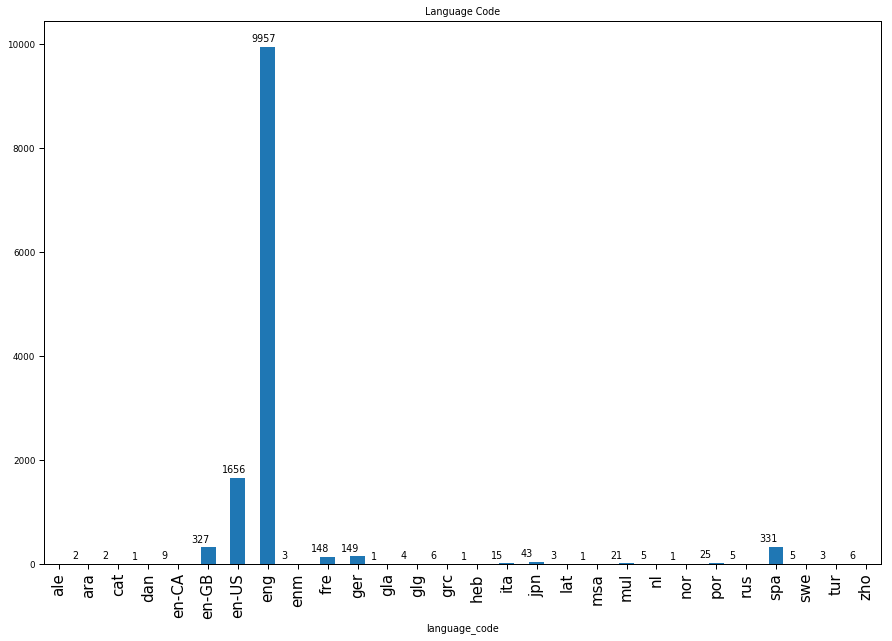

In [601]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

### From the above graph we can see that the majority of books are in english, hence for the sake of the experiment we will drop all the other language columns and one-hot encode the language column to add more info to our prediction done later.

In [604]:
df = pd.concat([df.drop('language_code', axis=1), pd.get_dummies(df['language_code'], prefix='language_code', prefix_sep='_', drop_first=True)], axis=1)

Perhaps from our earlier analysis we might be able to discern that the author's previous number of publications can help our prediciton model as well:

In [605]:
def value_rank(value_column,df):
    '''
    Inputs:
    value_column = the column we want to create a ranked version of e.g. Author
    df = the data frame to be processed 
    
    Outputs:
    df = data frame with the ranked column created for the value_column input 
    
    
    '''
    TargetColumnName=value_column+'_rank'
    df[TargetColumnName]=0
    counter = 0
    looper = 0
    for value in df[value_column]:
        for valueC in df[value_column]:
            if valueC == value:
                counter=counter+1
            else:
                continue
        df[TargetColumnName][looper]=counter
        looper=looper+1
        counter=0
    return df
        

In [606]:
intent='authors'
ranked_df=value_rank(intent,df)

D:\Conda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [607]:
intent='title'
ranked_df=value_rank(intent,ranked_df)

D:\Conda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [608]:
ranked_df.dtypes

bookID                   int64
title                   object
authors                 object
average_rating         float64
isbn                    object
isbn13                  object
# num_pages            float64
ratings_count            int64
text_reviews_count       int64
language_code_ara        uint8
language_code_cat        uint8
language_code_dan        uint8
language_code_en-CA      uint8
language_code_en-GB      uint8
language_code_en-US      uint8
language_code_eng        uint8
language_code_enm        uint8
language_code_fre        uint8
language_code_ger        uint8
language_code_gla        uint8
language_code_glg        uint8
language_code_grc        uint8
language_code_heb        uint8
language_code_ita        uint8
language_code_jpn        uint8
language_code_lat        uint8
language_code_msa        uint8
language_code_mul        uint8
language_code_nl         uint8
language_code_nor        uint8
language_code_por        uint8
language_code_rus        uint8
language

In [609]:
ranked_df=ranked_df.drop(['isbn','isbn13','title','bookID','authors','language_code_enm',
'language_code_fre',
'language_code_ger',
'language_code_glg',
'language_code_grc',
'language_code_heb',
'language_code_ita',
'language_code_jpn',
'language_code_lat',
'language_code_msa',
'language_code_mul',
'language_code_nl',
'language_code_nor',
'language_code_por',
'language_code_rus',
'language_code_spa',
'language_code_swe',
'language_code_tur',
'language_code_zho'], axis=1)

In [610]:
ranked_df=ranked_df.drop(['language_code_ara','language_code_cat','language_code_dan','language_code_eng','language_code_gla'], axis=1)

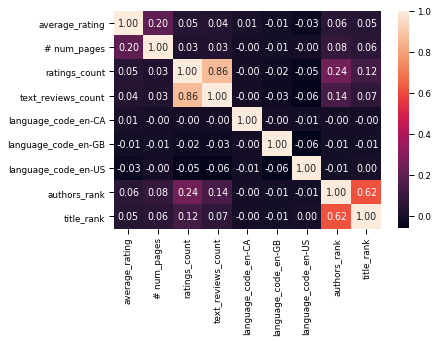

In [611]:
sns.heatmap(ranked_df.corr(), annot=True, fmt='.2f')

In [612]:
ratingsPred(ranked_df,responsecol)

'The r-squared score for your model was 0.050359161304314504 on 3820 values.'

## It seems that authors rank and book rank didnt have as much of an effect on the prediciton as hyopthesized. Lets investigate why:

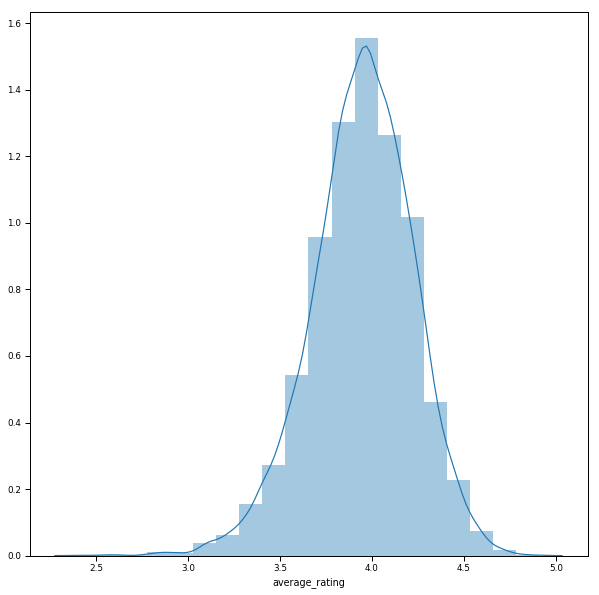

In [622]:
plt.figure(figsize=(10,10))
rating= ranked_df.average_rating.astype(float)
sns.distplot(rating, bins=20)

### As displayed on the above info graph, the bulk of the rating falls between 3.25 and 4.75 with the majority between the 3.5-4.5 mark.

<Figure size 1080x720 with 0 Axes>

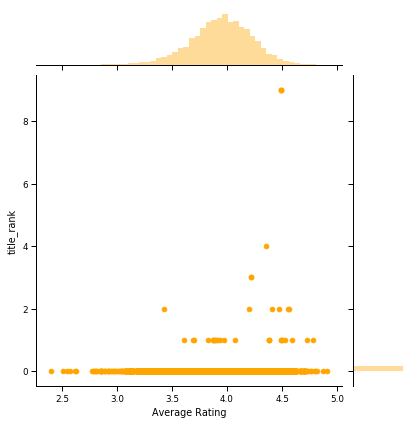

In [614]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="title_rank", data = ranked_df, color = 'orange')
ax.set_axis_labels("Average Rating", "title_rank")

### As per the above graph that displays the average rating across title rank. It seems that the book sthat have been published many times all fall within the normal range of 3.5-4.5. Hence how many times a book has been published still does not mean a higher than normal rating.

<Figure size 1080x720 with 0 Axes>

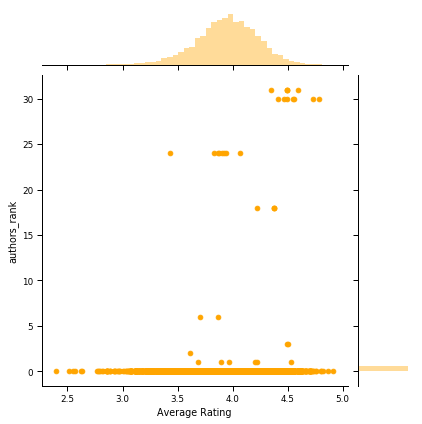

In [619]:


plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="authors_rank", data = ranked_df, color = 'orange')
ax.set_axis_labels("Average Rating", "authors_rank")

#### With the author rank comes a bit more information entropy. As we have the higher up ranked authors (over 25) having ratings that fall between 4.0-4.5. Which goes without saying that of course the most popular authors having a higher than normal rating, otherwise they wouldnt be popular. ;)

## With all relevant columns in place, I think its fair to now conclude that predicting the rating of a book based on the book's features is incoclusive. While the author's ranking, the number of pages and the ratings count as well as the text review count all play a factor in calculating an educated estimate of the rating, they are still not enough without the actual content of the book. Which is good news for book lovers :)

### So with the above colcuded we can now revise the initial hypothesis questions:

    * Does the reoccurance of a book through different publications bias the rating?
        * It does not as we investigated earlier, the results show that books that have been published many times dont necesarrily have higher than normal ratings (3.5-4.5 rating)
    * Does the ratings count and text review counts affect the rating
        * Yes, but to a small degree as it is clear that the books with higher than average ratings count and text review count still fall within the normal range 
    * Does the popularity of the author affect the rating?
        * Yes as it is shown that the writers with a higher rank fall within a higher than normal ratings bracket 4.0-4.5
   
